In [1]:
import os
import cv2 
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf 
import matplotlib.pyplot as plt   
from sklearn.utils import shuffle  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-02-17 13:36:49.155683: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 13:36:49.157111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 13:36:49.190546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 13:36:49.191193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 13:36:49.768868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)
nb_classes

6

In [3]:
def load_data(num_images_per_class=1000):
    
    datasets = ['/home/sesna/sesna/image_classification/data', '/home/sesna/sesna/image_classification/seg_test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Track the number of images loaded for each class
            images_loaded = 0
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                if images_loaded >= num_images_per_class:
                    break  # Break the loop if the desired number of images is reached for this class
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images.append(image)
                labels.append(label)
                
                # Increment the count of images loaded for this class
                images_loaded += 1
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')   
        
        output.append((images, labels))

    return output


In [4]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [5]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names,name):
    CM = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots()                                                           # Set up the matplotlib figure
    sns.heatmap(CM, annot=True, annot_kws={"size": 10}, 
                xticklabels=class_names, yticklabels=class_names, ax=ax)               # Create a heatmap using Seaborn
    ax.set_title('Confusion Matrix')   
    plt.savefig(name)                                                                  # Set the title
    plt.show()

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /home/sesna/sesna/image_classification/data


 44%|████▍     | 1000/2271 [00:00<00:00, 1619.72it/s]


Loading /home/sesna/sesna/image_classification/seg_test


100%|██████████| 474/474 [00:00<00:00, 1621.66it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 6000
Number of testing examples: 3000
Each image is of size: (150, 150)


In [9]:
train_images = train_images / 255.0 


In [10]:
test_images = test_images / 255.0

In [11]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [12]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.4)

Epoch 1/10
29/29 [==============================] - 15s 497ms/step - loss: 1.7027 - accuracy: 0.4000 - val_loss: 1.1543 - val_accuracy: 0.5354
Epoch 2/10
29/29 [==============================] - 14s 477ms/step - loss: 1.0156 - accuracy: 0.6122 - val_loss: 0.9688 - val_accuracy: 0.6271
Epoch 3/10
29/29 [==============================] - 14s 475ms/step - loss: 0.8382 - accuracy: 0.6958 - val_loss: 0.9351 - val_accuracy: 0.6517
Epoch 4/10
29/29 [==============================] - 14s 476ms/step - loss: 0.7294 - accuracy: 0.7392 - val_loss: 0.8123 - val_accuracy: 0.7000
Epoch 5/10
29/29 [==============================] - 14s 478ms/step - loss: 0.6006 - accuracy: 0.7869 - val_loss: 0.7417 - val_accuracy: 0.7396
Epoch 6/10
29/29 [==============================] - 14s 492ms/step - loss: 0.4864 - accuracy: 0.8331 - val_loss: 0.8034 - val_accuracy: 0.7221
Epoch 7/10
29/29 [==============================] - 14s 500ms/step - loss: 0.4480 - accuracy: 0.8494 - val_loss: 0.9411 - val_accuracy: 0.6687

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [15]:
with open('training_history.pkl', 'wb') as file:
   pickle.dump(history.history, file)

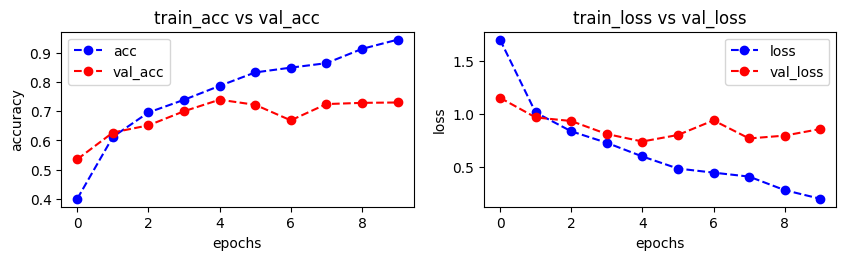

In [16]:
plot_accuracy_loss(history)

In [17]:
test_loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy}')


94/94 [==============================] - 3s 33ms/step - loss: 0.9144 - accuracy: 0.7100
Test Loss: 0.914380669593811
Test Accuracy: 0.7099999785423279


In [18]:
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 
Accuracy = accuracy_score(test_labels,pred_labels)
Accuracy *100

94/94 [==============================] - 3s 34ms/step


71.0

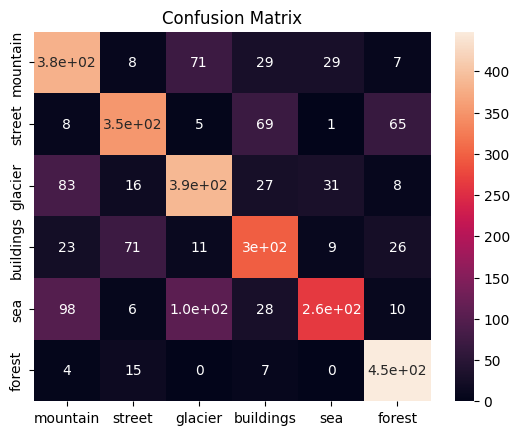

In [27]:
plot_confusion_matrix(test_labels,pred_labels,class_names,'confusion.png')

In [20]:
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [22]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.4, random_state=42)

In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [24]:
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding your own top layers on top of the pre-trained VGG16 base
model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [25]:
# Compile the model
model1.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Train the model
history1 = model1.fit(train_images, train_labels, validation_split=0.04,epochs=10, batch_size=128)

Epoch 1/10
17/17 [==============================] - 93s 6s/step - loss: 0.0292 - accuracy: 0.9952 - val_loss: 0.7813 - val_accuracy: 0.8276
Epoch 2/10
17/17 [==============================] - 102s 6s/step - loss: 0.0185 - accuracy: 0.9981 - val_loss: 0.6852 - val_accuracy: 0.8276
Epoch 3/10
17/17 [==============================] - 101s 6s/step - loss: 0.0235 - accuracy: 0.9952 - val_loss: 0.8470 - val_accuracy: 0.8276
Epoch 4/10
17/17 [==============================] - 101s 6s/step - loss: 0.0153 - accuracy: 0.9976 - val_loss: 1.0006 - val_accuracy: 0.7931
Epoch 5/10
17/17 [==============================] - 101s 6s/step - loss: 0.0116 - accuracy: 0.9986 - val_loss: 0.8780 - val_accuracy: 0.8276
Epoch 6/10
17/17 [==============================] - 101s 6s/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.8608 - val_accuracy: 0.8046
Epoch 7/10
17/17 [==============================] - 101s 6s/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.8871 - val_accuracy: 0.8391
Epoch 8/10
17/

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [29]:
with open('training_history1.pkl', 'wb') as file:
   pickle.dump(history1.history, file)

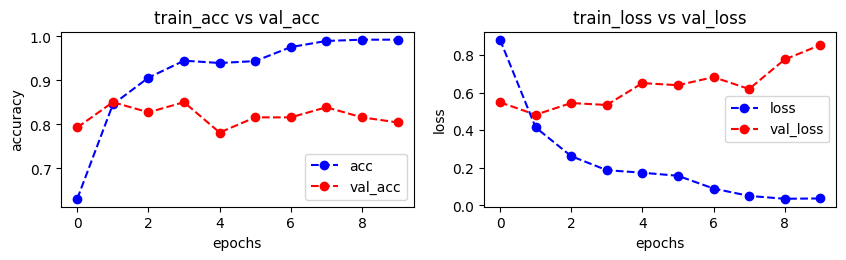

In [30]:
plot_accuracy_loss(history1)

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

94/94 [==============================] - 134s 1s/step - loss: 0.5361 - accuracy: 0.8457
Test Accuracy: 84.57%


In [38]:
predictions = model1.predict(test_images)     
pred_labels1 = np.argmax(predictions, axis = 1) 


94/94 [==============================] - 138s 1s/step


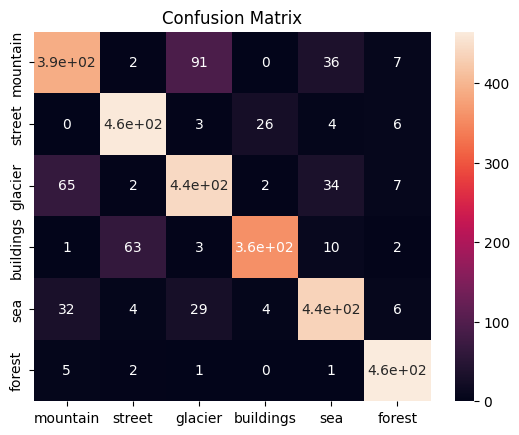

In [39]:
plot_confusion_matrix(test_labels,pred_labels1,class_names,'confusion1.png')

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','imageclassifier.h5'))

/home/sesna/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model1.save(os.path.join('models','imageclassifier1.h5'))